In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
import healpy as hp

In [2]:
nside = 128
# Connect to an opsim database, bleeding-edge sims here: 
# https://lsst-web.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs/
opsdb = db.OpsimDatabase('baseline_1exp_pairsmix_10yrs.db')
outDir = 'maf_out'
resultsDb = db.ResultsDb(outDir=outDir)
plotFuncs = [plots.TwoDMap()]

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night < 730 for columns ['fieldRA', 'night', 'fieldDec']
Found 116089 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night < 730" constraint now.
Plotting complete.


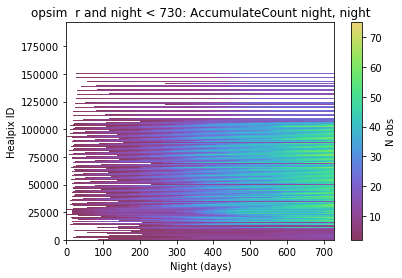

In [3]:
# Set metric to compute accumulated coadded depth per day for 10 years
filtername = 'r'
day_max = np.round(365.25*2)
bins = np.arange(day_max)
metric = metrics.AccumulateCountMetric(bins=bins)
slicer = slicers.HealpixSlicer(nside=nside)
plotDict = {'xlabel': 'Night (days)', 'cbarTitle': 'N obs', 'colorMax': 75}
# only use i-band
sql='filter = "%s" and night < %i' % (filtername, day_max)
bundle = metricBundles.MetricBundle(
    metric,slicer,sql, plotDict=plotDict, plotFuncs=plotFuncs)
group = metricBundles.MetricBundleGroup(
    {0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [4]:
bundle.metricValues

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., 18.0 18.0 18.0]
 [-- -- -- ..., 18.0 18.0 18.0]
 [-- -- -- ..., 15.0 15.0 15.0]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = -1.6375e+30)

In [5]:
n_val = 3

# Ugh, can't figure out how to do this properly with slicing
time_to_val = np.zeros(bundle.metricValues[:,0].size)
first_obs = np.zeros(time_to_val.size)
for i in np.arange(time_to_val.size):
    good = np.where(bundle.metricValues[i,:] > 0)[0]
    if np.size(good) > 0:
        first_obs[i] = bins[np.min(good)]
    else:
        first_obs[i] = hp.UNSEEN
    good = np.where(bundle.metricValues[i,:] > n_val)[0]
    if good.size > 0:
        
        time_to_val[i] = bins[good.min()]
    else:
        time_to_val[i] = hp.UNSEEN


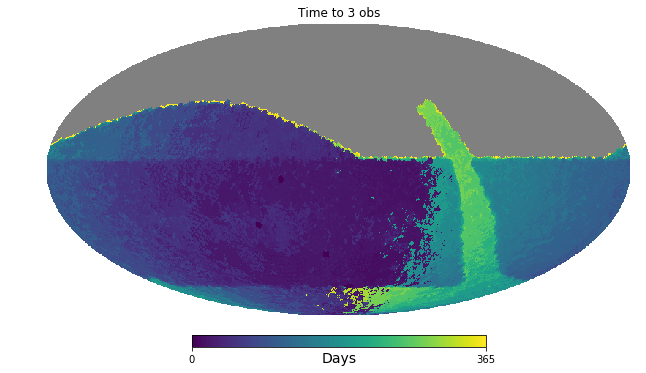

In [6]:
hp.mollview(time_to_val, title='Time to %i obs' % n_val, unit='Days', max=365)

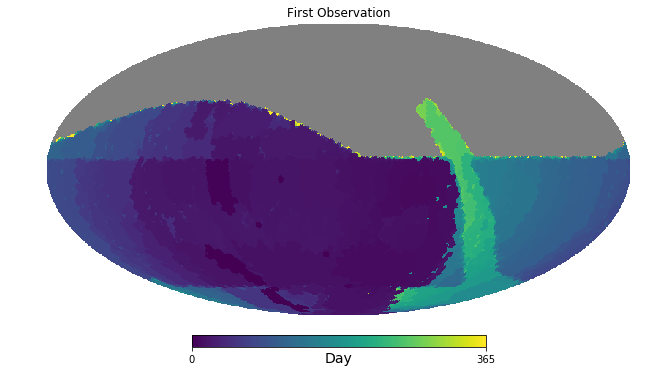

In [7]:
hp.mollview(first_obs, title='First Observation' , unit='Day', max=365)

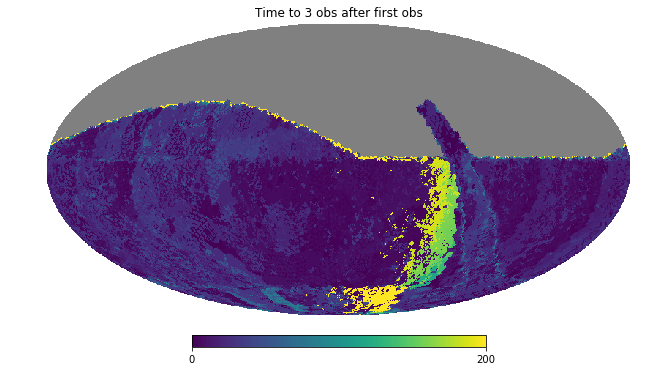

In [8]:
diff = time_to_val-first_obs
mask = np.where((time_to_val == hp.UNSEEN) | (first_obs == hp.UNSEEN))
diff[mask] = hp.UNSEEN
hp.mollview(diff, title = 'Time to %i obs after first obs' % n_val, max=200)

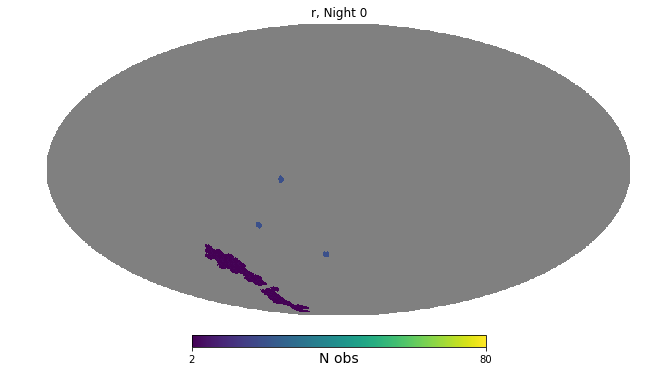

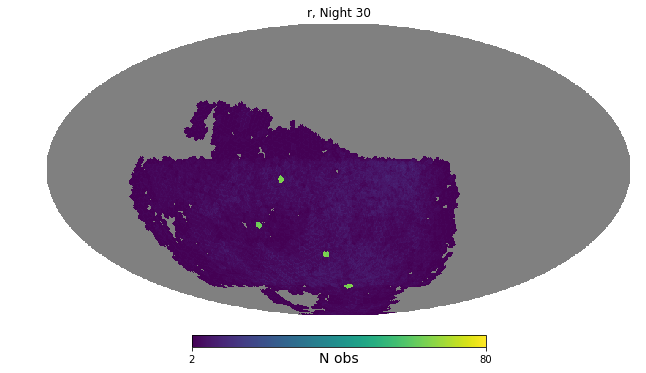

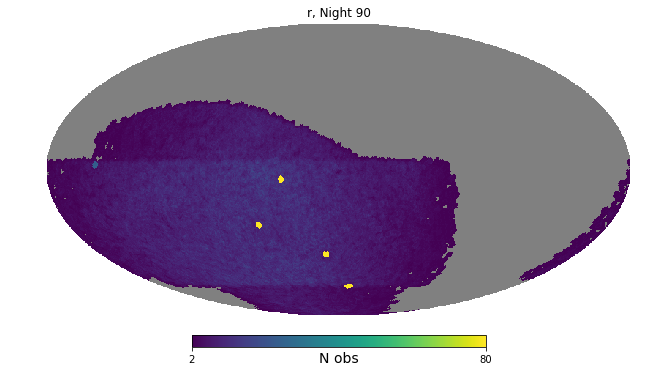

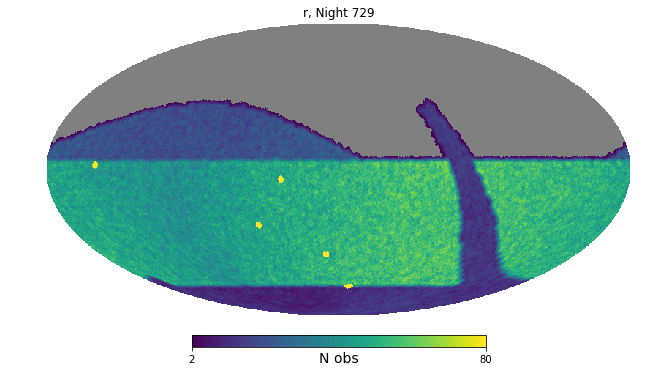

In [9]:
# Can plot movie frames and combine by plotting slices. Could do a log stretch if you want to watch 
# the DDFs build up.
for i in [0,30,90,-1]:
    hp.mollview(bundle.metricValues[:,i], max=80, unit='N obs', title='%s, Night %i' % (filtername, bins[i]))


In [13]:
outDir = 'movie_plots'
for i in np.arange(bundle.metricValues[0,:].size):
    hp.mollview(bundle.metricValues[:,i], max=80, unit='N obs', title='%s, Night %i' % (filtername, bins[i]))
    plt.savefig(outDir+'/%i.png' % i)
    plt.close()

In [ ]:
#  ffmpeg -framerate 4 -pix_fmt yuv420p  -i %d.png r_band.mp4